In [1]:
!pip install --quiet scikit-fuzzy scikit-learn pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.1 MB/s eta 0:00:00


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
confusion_matrix, roc_auc_score, roc_curve, classification_report)
import warnings
warnings.filterwarnings('ignore')

In [15]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
cols = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']
df = pd.read_csv(url, header=None, names=cols)
print('Dataset shape:', df.shape)
print(df.head())

Dataset shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [16]:
print('\nValue counts (Outcome):')
print(df['Outcome'].value_counts())
print('\nSummary stats:')
print(df.describe())


Value counts (Outcome):
Outcome
0    500
1    268
Name: count, dtype: int64

Summary stats:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.8

In [17]:
cols_with_zero_missing = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for c in cols_with_zero_missing:
  n_zero = (df[c] == 0).sum()
  print(f'Column {c} has {n_zero} zeros (treated as missing)')


# Impute zeros with median of the column
for c in cols_with_zero_missing:
  median_val = df.loc[df[c] != 0, c].median()
  df.loc[df[c] == 0, c] = median_val


print('\nAfter imputation summary:')
print(df.describe())

Column Glucose has 5 zeros (treated as missing)
Column BloodPressure has 35 zeros (treated as missing)
Column SkinThickness has 227 zeros (treated as missing)
Column Insulin has 374 zeros (treated as missing)
Column BMI has 11 zeros (treated as missing)

After imputation summary:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      29.108073  140.671875   
std       3.369578   30.438286      12.096642       8.791221   86.383060   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigre

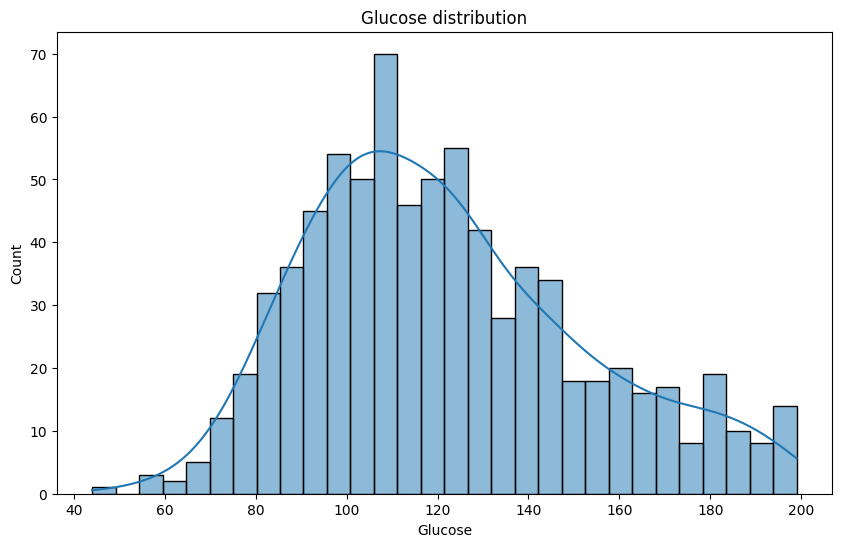

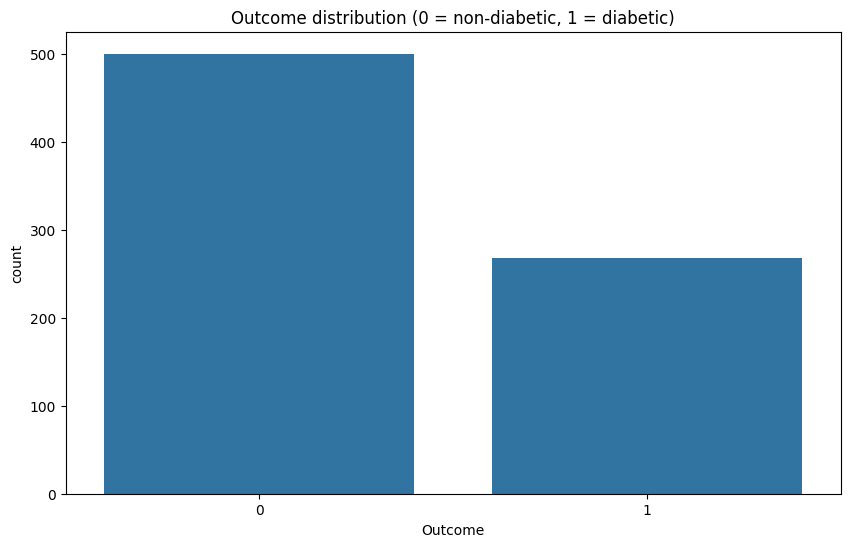

In [18]:
plt.figure(figsize=(10,6))
sns.histplot(df['Glucose'], bins=30, kde=True)
plt.title('Glucose distribution')
plt.show()


plt.figure(figsize=(10,6))
sns.countplot(x='Outcome', data=df)
plt.title('Outcome distribution (0 = non-diabetic, 1 = diabetic)')
plt.show()

In [19]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# RandomForest with a small grid search (fast)
from sklearn.ensemble import RandomForestClassifier

rfc_best = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

rfc_best.fit(X_train, y_train)
rfc_pred = rfc_best.predict(X_test)
rfc_probs = rfc_best.predict_proba(X_test)[:,1]


print('\nRandomForest classification report:')
print(classification_report(y_test, rfc_pred))
print('Accuracy:', accuracy_score(y_test, rfc_pred))
print('Precision:', precision_score(y_test, rfc_pred))
print('Recall:', recall_score(y_test, rfc_pred))
print('F1:', f1_score(y_test, rfc_pred))
print('AUC:', roc_auc_score(y_test, rfc_probs))


RandomForest classification report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82       150
           1       0.70      0.53      0.61        81

    accuracy                           0.76       231
   macro avg       0.74      0.71      0.72       231
weighted avg       0.75      0.76      0.75       231

Accuracy: 0.7575757575757576
Precision: 0.7049180327868853
Recall: 0.5308641975308642
F1: 0.6056338028169014
AUC: 0.8364609053497942


In [29]:
#FIS Implementation
glucose_range = np.arange(40, 301, 1) # glucose mg/dL
bmi_range = np.arange(10, 60.1, 0.1) # BMI
bp_range = np.arange(40, 141, 1) # BloodPressure
age_range = np.arange(10, 101, 1) # Age years
pedigree_range = np.arange(0, 3.01, 0.01) # DPF typically 0-2.5
insulin_range = np.arange(15, 401, 1) # Insulin rough range (adjusted)
risk_range = np.arange(0, 101, 1) # Risk score 0-100


# Create Antecedents and Consequent
glucose = ctrl.Antecedent(glucose_range, 'glucose')
bmi = ctrl.Antecedent(bmi_range, 'bmi')
bp = ctrl.Antecedent(bp_range, 'bp')
age = ctrl.Antecedent(age_range, 'age')
pedigree = ctrl.Antecedent(pedigree_range, 'pedigree')
insulin = ctrl.Antecedent(insulin_range, 'insulin')


risk = ctrl.Consequent(risk_range, 'risk')

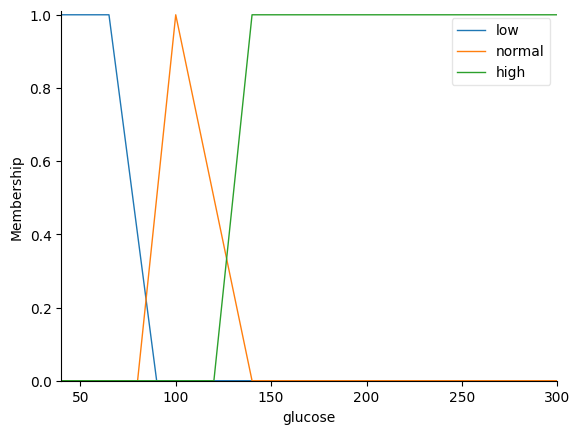

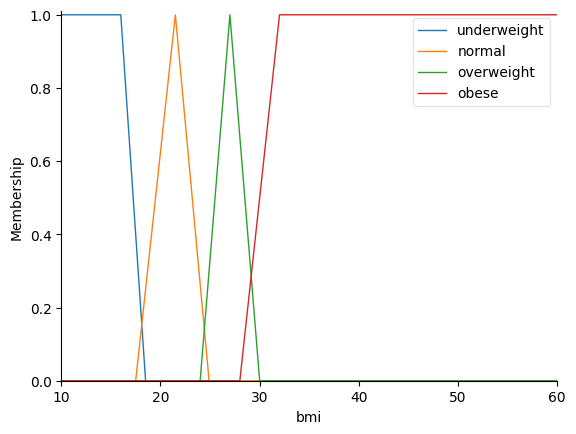

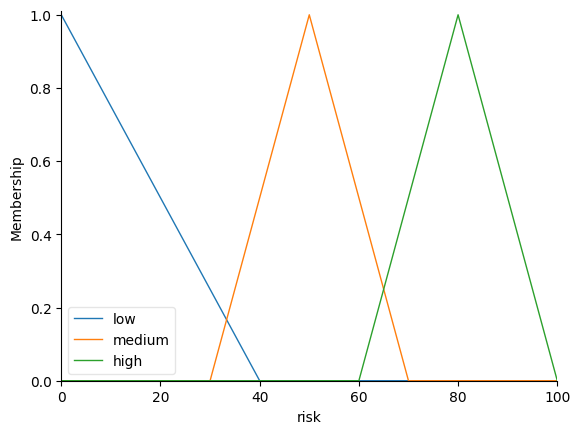

In [30]:
# Glucose: Low / Normal / High
glucose['low'] = fuzz.trapmf(glucose.universe, [40,40,65,90])
glucose['normal'] = fuzz.trimf(glucose.universe, [80,100,140])
glucose['high'] = fuzz.trapmf(glucose.universe, [120,140,300,300])

# BMI: Underweight / Normal / Overweight / Obese
bmi['underweight'] = fuzz.trapmf(bmi.universe, [10,10,16,18.5])
bmi['normal'] = fuzz.trimf(bmi.universe, [17.5,21.5,24.9])
bmi['overweight'] = fuzz.trimf(bmi.universe, [24,27,30])
bmi['obese'] = fuzz.trapmf(bmi.universe, [28,32,60,60])

# Blood Pressure: Low / Normal / High
bp['low'] = fuzz.trapmf(bp.universe, [40,40,60,80])
bp['normal'] = fuzz.trimf(bp.universe, [75,90,110])
bp['high'] = fuzz.trapmf(bp.universe, [100,120,140,140])

# Age: Young / Middle / Old
age['young'] = fuzz.trapmf(age.universe, [10,10,25,35])
age['middle'] = fuzz.trimf(age.universe, [30,40,55])
age['old'] = fuzz.trapmf(age.universe, [50,65,100,100])

# Pedigree: Low / Medium / High
pedigree['low'] = fuzz.trapmf(pedigree.universe, [0,0,0.2,0.5])
pedigree['medium'] = fuzz.trimf(pedigree.universe, [0.3,0.6,1.0])
pedigree['high'] = fuzz.trapmf(pedigree.universe, [0.8,1.2,3.0,3.0])

# Insulin: Low / Normal / High (values depend; we adjusted universe)
insulin['low'] = fuzz.trapmf(insulin.universe, [15,15,40,90])
insulin['normal'] = fuzz.trimf(insulin.universe, [80,120,200])
insulin['high'] = fuzz.trapmf(insulin.universe, [160,220,400,400])

# Risk: Low / Medium / High (0-100 scale)
risk['low'] = fuzz.trimf(risk.universe, [0,0,40])
risk['medium'] = fuzz.trimf(risk.universe, [30,50,70])
risk['high'] = fuzz.trimf(risk.universe, [60,80,100])

# Plot sample MFs for documentation
glucose.view()
bmi.view()
risk.view()

In [31]:
rules = []
# Strong glucose rules
rules.append(ctrl.Rule(glucose['high'], risk['high']))
rules.append(ctrl.Rule(glucose['normal'] & bmi['normal'], risk['low']))

# Glucose + Age
rules.append(ctrl.Rule(glucose['high'] & age['old'], risk['high']))
rules.append(ctrl.Rule(glucose['high'] & age['middle'], risk['high']))
rules.append(ctrl.Rule(glucose['normal'] & age['young'], risk['low']))

# BMI influence
rules.append(ctrl.Rule(bmi['obese'] & glucose['normal'], risk['medium']))
rules.append(ctrl.Rule(bmi['obese'] & bp['high'], risk['high']))

# Pedigree influence
rules.append(ctrl.Rule(pedigree['high'] & glucose['normal'], risk['medium']))
rules.append(ctrl.Rule(pedigree['high'] & age['old'], risk['medium']))

# Insulin low with high glucose -> high risk
rules.append(ctrl.Rule(glucose['high'] & insulin['low'], risk['high']))

# glucose low and bmi underweight -> low
rules.append(ctrl.Rule(glucose['low'] & bmi['underweight'], risk['low']))

# Insulin high with glucose normal -> medium
rules.append(ctrl.Rule(insulin['high'] & glucose['normal'], risk['medium']))

# BP influence
rules.append(ctrl.Rule(bp['high'] & bmi['obese'], risk['high']))
rules.append(ctrl.Rule(bp['normal'] & glucose['normal'], risk['low']))

# Young and normal everything -> low
rules.append(ctrl.Rule(age['young'] & glucose['normal'] & bmi['normal'], risk['low']))
rules.append(ctrl.Rule(pedigree['medium'] & bmi['overweight'], risk['medium']))
rules.append(ctrl.Rule(insulin['low'] & pedigree['high'], risk['high']))

# Combination medium cases
rules.append(ctrl.Rule(glucose['normal'] & pedigree['medium'], risk['medium']))
rules.append(ctrl.Rule(bmi['overweight'] & glucose['normal'], risk['medium']))

# Fallback rule
rules.append(ctrl.Rule(glucose['low'] & bmi['underweight'], risk['low']))
rules.append(ctrl.Rule(glucose['high'] | bp['high'], risk['medium']))

#catch all
catch_all = ctrl.Rule(glucose['low'] | glucose['normal'] | glucose['high'], risk['medium'])
rules.append(catch_all)
# Create control system
risk_ctrl = ctrl.ControlSystem(rules)
risk_sim = ctrl.ControlSystemSimulation(risk_ctrl)

In [32]:
# Evaluate FIS on the test set
pred_scores = []
for idx, row in X_test.reset_index(drop=True).iterrows():
    # prepare inputs (example: clip to universes)
    g = float(row['Glucose'])
    b = float(row['BMI'])
    bp_v = float(row['BloodPressure'])
    ins = float(row['Insulin'])
    a = float(row['Age'])
    ped = float(row['DiabetesPedigreeFunction'])

    # quick sanity checks
    if any([pd.isna(v) for v in [g,b,bp_v,ins,a,ped]]):
        print('NaN at idx', idx, row[[ 'Glucose','BMI','BloodPressure','Insulin','Age','DiabetesPedigreeFunction']])
        pred_scores.append(50.0)
        continue

    # clip to universes to avoid out-of-range values
    g = np.clip(g, glucose.universe.min(), glucose.universe.max())
    b = np.clip(b, bmi.universe.min(), bmi.universe.max())
    bp_v = np.clip(bp_v, bp.universe.min(), bp.universe.max())
    ins = np.clip(ins, insulin.universe.min(), insulin.universe.max())
    a = np.clip(a, age.universe.min(), age.universe.max())
    ped = np.clip(ped, pedigree.universe.min(), pedigree.universe.max())


    risk_sim.reset()
    risk_sim.input['glucose'] = g
    risk_sim.input['bmi'] = b
    risk_sim.input['bp'] = bp_v
    risk_sim.input['age'] = a
    risk_sim.input['pedigree'] = ped
    risk_sim.input['insulin'] = ins

    try:
        risk_sim.compute()
        # defensive access: check output key
        if 'risk' in risk_sim.output:
            s = float(risk_sim.output['risk'])
        else:
            print('No risk in output at idx', idx, 'inputs:', g,b,bp_v,ins,a,ped)
            s = 50.0
    except Exception as e:
        print('Warning: FIS compute issue at index', idx, repr(e))
        # print inputs for debugging
        print('  inputs:', {'glucose':g, 'bmi':b, 'bp':bp_v, 'insulin':ins, 'age':a, 'pedigree':ped})
        s = 50.0

    pred_scores.append(s)

pred_scores = np.array(pred_scores)
# Continuous AUC (use normalized score 0-1)
auc_fis = roc_auc_score(y_test.reset_index(drop=True), pred_scores/100)
print('FIS continuous score AUC:', auc_fis)

# Try binary mapping thresholds and show metrics
def evaluate_threshold(thresh):
  pred_binary = (pred_scores >= thresh).astype(int)
  acc = accuracy_score(y_test.reset_index(drop=True), pred_binary)
  prec = precision_score(y_test.reset_index(drop=True), pred_binary)
  rec = recall_score(y_test.reset_index(drop=True), pred_binary)
  f1 = f1_score(y_test.reset_index(drop=True), pred_binary)
  return acc, prec, rec, f1

for t in [40,50,60]:
  acc, prec, rec, f1 = evaluate_threshold(t)
  print(f'Threshold {t}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}')

# Choose threshold by maximizing F1 (quick search)
best_t = None
best_f1 = -1
for t in range(30,71):
  _, _, _, f1 = evaluate_threshold(t)
  if f1 > best_f1:
    best_f1 = f1
    best_t = t
print('Best threshold by F1:', best_t, 'with F1=', best_f1)

FIS continuous score AUC: 0.7794650205761317
Threshold 40: Accuracy=0.6580, Precision=0.5075, Recall=0.8395, F1=0.6326
Threshold 50: Accuracy=0.7229, Precision=0.5825, Recall=0.7407, F1=0.6522
Threshold 60: Accuracy=0.7013, Precision=0.5789, Recall=0.5432, F1=0.5605
Best threshold by F1: 51 with F1= 0.655367231638418


FIS classification report (threshold chosen by F1):
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       150
           1       0.60      0.72      0.66        81

    accuracy                           0.74       231
   macro avg       0.72      0.73      0.72       231
weighted avg       0.75      0.74      0.74       231

Confusion matrix:


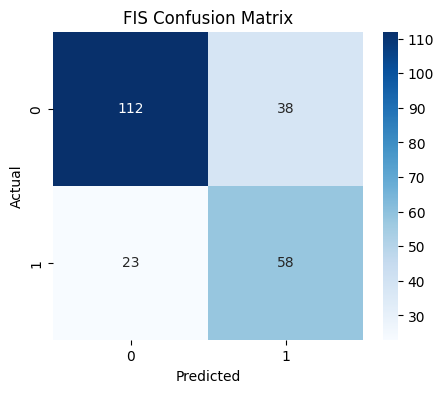

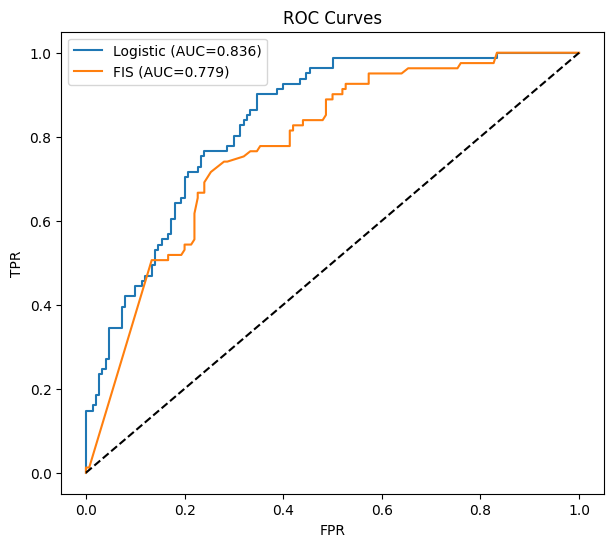

In [33]:
# Final binary predictions
final_thresh = best_t
pred_binary_final = (pred_scores >= final_thresh).astype(int)
print('FIS classification report (threshold chosen by F1):')
print(classification_report(y_test.reset_index(drop=True), pred_binary_final))
print('Confusion matrix:')
cm = confusion_matrix(y_test.reset_index(drop=True), pred_binary_final)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('FIS Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC curves for both methods
fpr_lr, tpr_lr, _ = roc_curve(y_test, probs_lr)
fpr_fis, tpr_fis, _ = roc_curve(y_test, pred_scores/100)
plt.figure(figsize=(7,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic (AUC={roc_auc_score(y_test,probs_lr):.3f})')
plt.plot(fpr_fis, tpr_fis, label=f'FIS (AUC={roc_auc_score(y_test,pred_scores/100):.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [35]:
# 7) Minimal Diet Recommender (uses predicted risk class)
# The recommender will be intentionally small and rule-based as required by the project brief.
def risk_to_class(score):
  # Use the same thresholds as mapping earlier: 0-<best_t -> Low, >=best_t and <80 -> Medium, >=80 -> High
  if score < final_thresh:
    return 'Low'
  elif score < 80:
    return 'Medium'
  else:
    return 'High'

def recommend_diet(risk_score):
  cls = risk_to_class(risk_score)
  rec = {'risk_score': round(float(risk_score),2), 'risk_class': cls}
  if cls == 'Low':
    rec['calorie_advice'] = 'Maintain current calorie intake; focus on balanced macros.'
    rec['carb_guideline'] = '50-55% of calories from complex carbs; avoid sugary drinks.'
    rec['foods_prefer'] = ['Whole grains', 'Leafy vegetables', 'Lean protein', 'Legumes']
    rec['foods_avoid'] = ['Sugary beverages', 'Refined carbs', 'Excess fried food']
  elif cls == 'Medium':
    rec['calorie_advice'] = 'Reduce daily calories by ~10% and monitor weight.'
    rec['carb_guideline'] = 'Limit simple carbs; prioritize low-GI carbs and fiber.'
    rec['foods_prefer'] = ['Oats', 'Quinoa', 'Vegetables', 'Nuts', 'Fish/lean poultry']
    rec['foods_avoid'] = ['Sweets', 'White bread', 'Sugary desserts', 'High-fat processed foods']
  else: # High
    rec['calorie_advice'] = 'Consider 15-20% calorie reduction; consult a healthcare professional.'
    rec['carb_guideline'] = 'Strict carb control; monitor portion sizes and carbohydrate counting.'
    rec['foods_prefer'] = ['Non-starchy vegetables', 'High-fiber foods', 'Lean protein', 'Legumes']
    rec['foods_avoid'] = ['Sugary snacks', 'Sweetened beverages', 'Large portions of rice/pasta', 'Processed foods']
  return rec

In [36]:
# Demo: show diet recommendations for a few sample patients from test set
sample_indexes = [0, 5, 10]
print('\nSample diet recommendations (from test set examples):')
for i in sample_indexes:
    score = pred_scores[i]
    d = recommend_diet(score)
    print('\nPatient index (test subset):', i, ' -> Risk score:', d['risk_score'], 'Class:', d['risk_class'])
    print('Calorie advice:', d['calorie_advice'])
    print('Carb guideline:', d['carb_guideline'])
    print('Prefer:', ', '.join(d['foods_prefer']))
    print('Avoid:', ', '.join(d['foods_avoid']))


Sample diet recommendations (from test set examples):

Patient index (test subset): 0  -> Risk score: 56.1 Class: Medium
Calorie advice: Reduce daily calories by ~10% and monitor weight.
Carb guideline: Limit simple carbs; prioritize low-GI carbs and fiber.
Prefer: Oats, Quinoa, Vegetables, Nuts, Fish/lean poultry
Avoid: Sweets, White bread, Sugary desserts, High-fat processed foods

Patient index (test subset): 5  -> Risk score: 31.62 Class: Low
Calorie advice: Maintain current calorie intake; focus on balanced macros.
Carb guideline: 50-55% of calories from complex carbs; avoid sugary drinks.
Prefer: Whole grains, Leafy vegetables, Lean protein, Legumes
Avoid: Sugary beverages, Refined carbs, Excess fried food

Patient index (test subset): 10  -> Risk score: 33.12 Class: Low
Calorie advice: Maintain current calorie intake; focus on balanced macros.
Carb guideline: 50-55% of calories from complex carbs; avoid sugary drinks.
Prefer: Whole grains, Leafy vegetables, Lean protein, Legume

In [39]:
# Save results, outputs, and provide quick report summary variables
results = {
'fuzzy_system': {
'auc': auc_fis,
'best_threshold': final_thresh,
'f1': best_f1
}
}

print('\nSummary of key results:')
print(results)

# Save prediction scores and recommendations to CSV for quick review
out_df = X_test.reset_index(drop=True)
out_df['Outcome'] = y_test.reset_index(drop=True)
out_df['FIS_RiskScore'] = pred_scores
out_df['FIS_Prediction'] = pred_binary_final

# Add diet mapping
out_df['Diet_Risk_Class'] = out_df['FIS_RiskScore'].apply(lambda x: risk_to_class(x))

# Add detailed diet recommendations to out_df for all patients
recommendation_details = out_df['FIS_RiskScore'].apply(lambda x: recommend_diet(x))
out_df['Calorie_Advice'] = recommendation_details.apply(lambda x: x['calorie_advice'])
out_df['Carb_Guideline'] = recommendation_details.apply(lambda x: x['carb_guideline'])
out_df['Foods_Prefer'] = recommendation_details.apply(lambda x: ', '.join(x['foods_prefer']))
out_df['Foods_Avoid'] = recommendation_details.apply(lambda x: ', '.join(x['foods_avoid']))

out_df.to_csv('fuzzy_diabetes_results.csv', index=False)
print('\nSaved fuzzy_diabetes_results.csv to current directory.')


Summary of key results:
{'fuzzy_system': {'auc': np.float64(0.7794650205761317), 'best_threshold': 51, 'f1': 0.655367231638418}}

Saved fuzzy_diabetes_results.csv to current directory.


In [40]:
from google.colab import files
files.download('fuzzy_diabetes_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>